In [94]:
from astropy.io import fits
import glob
from astropy.io import ascii
import os
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

In [7]:
datadir = '/n/holyscratch01/conroy_lab/vchandra/mage/'
#datadir = '/n/holystore01/LABS/conroy_lab/Lab/vchandra/mage/'

In [9]:
allnights = glob.glob(datadir + 'data/*')

In [16]:
nights = [];
for path in allnights:
    night = os.path.basename(path)

    if 'b' not in night and '202' in night:
        nights.append(night)

nights = np.sort(nights)

In [17]:
nights

array(['2022_08_03', '2022_08_04', '2022_08_05', '2022_08_24',
       '2022_10_21', '2022_11_03', '2022_12_18', '2022_12_19',
       '2023_01_29', '2023_02_07', '2023_02_08', '2023_03_06',
       '2023_03_12', '2023_03_28', '2023_04_29', '2023_04_30',
       '2023_05_29', '2023_06_11', '2023_08_16', '2023_10_13',
       '2023_11_05', '2023_12_03', '2023_12_12', '2023_12_20',
       '2024_02_25', '2024_03_18'], dtype='<U10')

In [89]:
rows = [];

for night in nights:

    print('==' * 10)
    print(night)
    ndir = datadir + 'data/' + night + '/'
    obslog = ascii.read(ndir + 'raw/obslog_edited.txt', format = 'fixed_width')
    sci = obslog['frametype'] == 'science'
    scitargets = np.unique(obslog['target'][sci])
    N_sci = len(scitargets)
    coadds = glob.glob(ndir + 'reduced_v0/magellan_mage_A/Science/coadd/*fits')
    coadd_names = [path.split('/')[-1].split('_')[0] for path in coadds]
    N_coadd = len(coadds)
    print('there are %i unique science targets and %i coadded spectra' % (N_sci, N_coadd))
    for target in scitargets:
        if target not in coadd_names:
            print('%s is a science target without a reduced, coadded spectrum!' % target)

    N_missing = N_sci - N_coadd

    out = {};

    out['night'] = night
    out['N_sci'] = N_sci
    out['N_coadd'] = N_coadd
    out['N_missing'] = N_missing

    rows.append(out)

2022_08_03
there are 21 unique science targets and 0 coadded spectra
hip4148 is a science target without a reduced, coadded spectrum!
hip77 is a science target without a reduced, coadded spectrum!
j0000m1137 is a science target without a reduced, coadded spectrum!
j2045m1858 is a science target without a reduced, coadded spectrum!
j2110m2425 is a science target without a reduced, coadded spectrum!
j2139m4847 is a science target without a reduced, coadded spectrum!
j2159m0853 is a science target without a reduced, coadded spectrum!
j2213m4259 is a science target without a reduced, coadded spectrum!
j2216p0414 is a science target without a reduced, coadded spectrum!
j2222m1555 is a science target without a reduced, coadded spectrum!
j2223m0725 is a science target without a reduced, coadded spectrum!
j2224p0647 is a science target without a reduced, coadded spectrum!
j2241m1443 is a science target without a reduced, coadded spectrum!
j2243m4111 is a science target without a reduced, coadd

In [92]:
tab = Table(rows)

Text(0, 0.5, 'fraction missing')

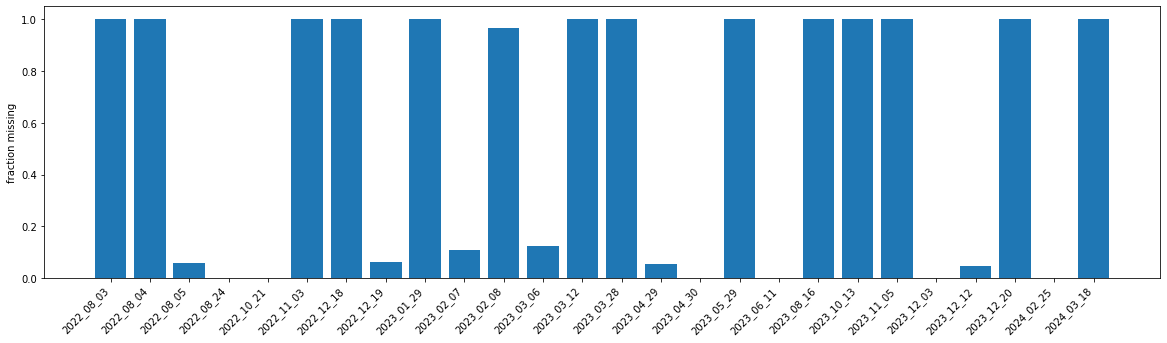

In [103]:
plt.figure(figsize = (20, 5))
plt.bar(tab['night'], tab['N_missing'] / tab['N_sci'])
plt.xticks(rotation = 45,  ha = 'right');
plt.ylabel('fraction missing')

In [38]:
night = '2022_11_03'

In [39]:
rawdir = datadir + 'data/' + night + '/raw/'

In [40]:
file = rawdir + 'mage1067.fits'

In [41]:
with fits.open(file, 'update') as f:
    print(f[0].header['OBJECT'])

None


In [42]:
with fits.open(file, 'update') as f:
    f[0].header['OBJECT'] = 'thar'

In [43]:
with fits.open(file) as f:
    print(f[0].header['OBJECT'])

thar
